In [21]:
import functools
import matplotlib.pyplot as plt
import numpy as np
import torch
import seaborn as sns

from network import Net, NetDiscovery
from diff_equations import *

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

sns.set_theme()
torch.manual_seed(42)

print(DEVICE)


cpu


# Cooling cup of coffee

Text(0.5, 0, 'Time (s)')

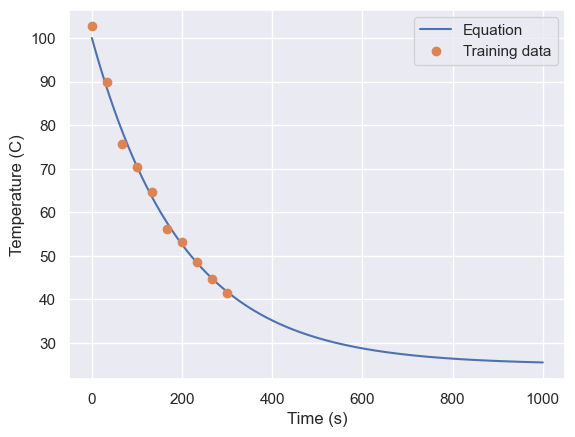

In [22]:
np.random.seed(10)

Tenv = 25 # degrees C
T0 = 100 # degrees C, hot coffee
R = 0.005
times = np.linspace(0, 1000, 1000)
eq = functools.partial(cooling_law, Tenv=Tenv, T0=T0, R=R)
temps = eq(times)

# Make training data
t = np.linspace(0, 300, 10)
T = eq(t) +  2 * np.random.randn(10)

plt.plot(times, temps)
plt.plot(t, T, 'o')
plt.legend(['Equation', 'Training data'])
plt.ylabel('Temperature (C)')
plt.xlabel('Time (s)')


# Vanilla Networks

Epoch 0/20000, loss: 4713.87
Epoch 2000/20000, loss: 2509.96
Epoch 4000/20000, loss: 2141.73
Epoch 6000/20000, loss: 727.16
Epoch 8000/20000, loss: 88.06
Epoch 10000/20000, loss: 2.06
Epoch 12000/20000, loss: 0.47
Epoch 14000/20000, loss: 0.40
Epoch 16000/20000, loss: 0.36
Epoch 18000/20000, loss: 0.34


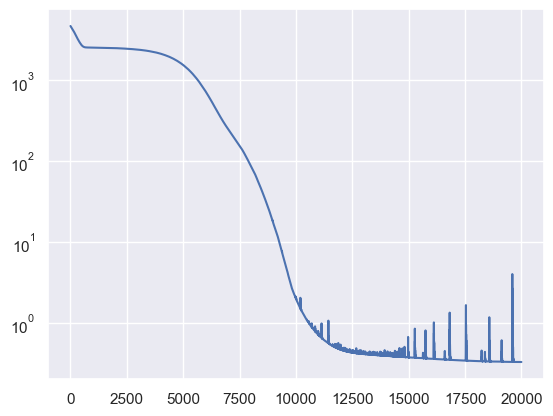

In [5]:
net = Net(1,1, loss2=None, epochs=20000, lr=1e-5).to(DEVICE)

losses = net.fit(t, T)

plt.plot(losses)
plt.yscale('log')

In [6]:
def l2_reg(model: torch.nn.Module):
    return torch.sum(sum([p.pow(2.) for p in model.parameters()]))

Epoch 0/20000, loss: 11219.99
Epoch 2000/20000, loss: 3911.79
Epoch 4000/20000, loss: 2422.38
Epoch 6000/20000, loss: 1600.79
Epoch 8000/20000, loss: 1191.39
Epoch 10000/20000, loss: 1004.83
Epoch 12000/20000, loss: 909.30
Epoch 14000/20000, loss: 836.83
Epoch 16000/20000, loss: 769.34
Epoch 18000/20000, loss: 710.06


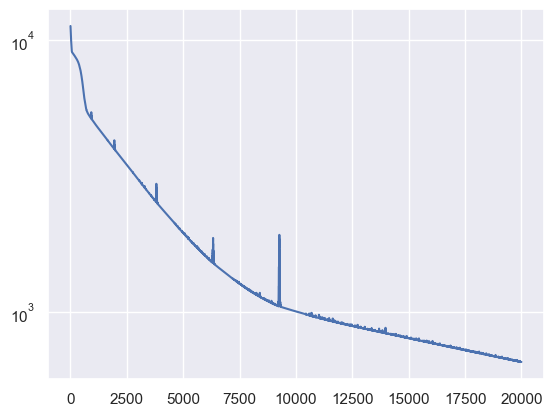

In [7]:
netreg = Net(1,1, loss2=l2_reg, epochs=20000, lr=1e-4, loss2_weight=1).to(DEVICE)

losses = netreg.fit(t, T)

plt.plot(losses)
plt.yscale('log')

Text(0.5, 0, 'Time (s)')

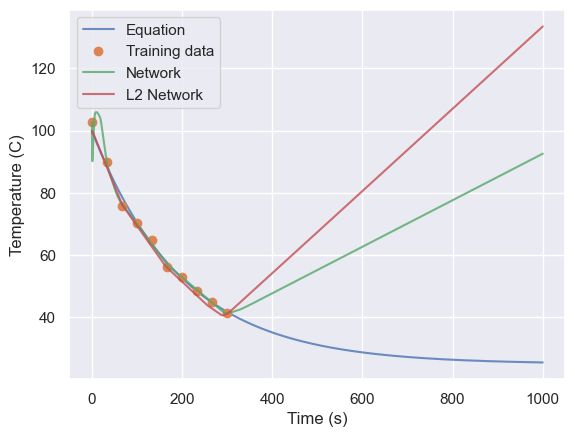

In [8]:
predsreg = netreg.predict(times)

preds = net.predict(times)
plt.plot(times, temps, alpha=0.8)
plt.plot(t, T, 'o')
plt.plot(times, preds, alpha=0.8)
plt.plot(times, predsreg, alpha=0.8)

plt.legend(labels=['Equation','Training data', 'Network', 'L2 Network'])
plt.ylabel('Temperature (C)')
plt.xlabel('Time (s)')


# PINN

In [9]:
def physics_loss(model: torch.nn.Module):
    ts = torch.linspace(0, 1000, steps=1000,).view(-1,1).requires_grad_(True).to(DEVICE)
    temps = model(ts)
    dT = grad(temps, ts)[0]
    pde = R*(Tenv - temps) - dT
    
    return torch.mean(pde**2)

Epoch 0/30000, loss: 4775.84
Epoch 3000/30000, loss: 2435.34
Epoch 6000/30000, loss: 541.90
Epoch 9000/30000, loss: 1.13
Epoch 12000/30000, loss: 0.41
Epoch 15000/30000, loss: 0.39
Epoch 18000/30000, loss: 0.36
Epoch 21000/30000, loss: 0.39
Epoch 24000/30000, loss: 0.33
Epoch 27000/30000, loss: 0.34


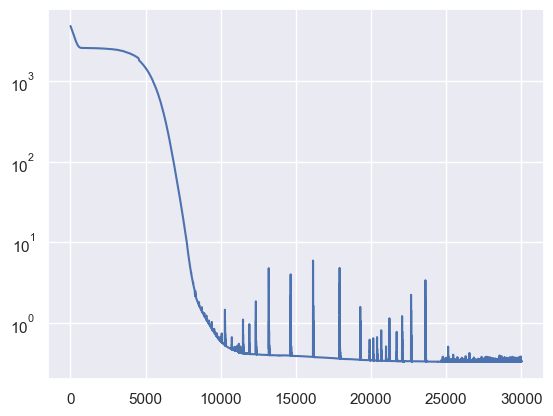

In [10]:
net = Net(1,1, loss2=physics_loss, epochs=30000, loss2_weight=1, lr=1e-5).to(DEVICE)

losses = net.fit(t, T)
plt.plot(losses)
plt.yscale('log')

Text(0.5, 0, 'Time (s)')

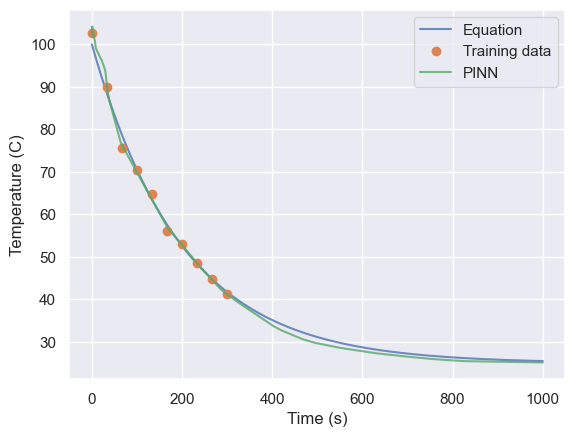

In [11]:
preds = net.predict(times)

plt.plot(times, temps, alpha=0.8)
plt.plot(t, T, 'o')
plt.plot(times, preds, alpha=0.8)
plt.legend(labels=['Equation','Training data', 'PINN'])
plt.ylabel('Temperature (C)')
plt.xlabel('Time (s)')

# Parameter discovery

In [12]:
def physics_loss_discovery(model: torch.nn.Module):
    ts = torch.linspace(0, 1000, steps=1000,).view(-1,1).requires_grad_(True).to(DEVICE)
    temps = model(ts)
    dT = grad(temps, ts)[0]
    pde = model.r * (Tenv - temps) - dT
    
    return torch.mean(pde**2)

Epoch 0/40000, loss: 4816.01
Epoch 4000/40000, loss: 2499.88
Epoch 8000/40000, loss: 2049.91
Epoch 12000/40000, loss: 490.19
Epoch 16000/40000, loss: 3.67
Epoch 20000/40000, loss: 1.43
Epoch 24000/40000, loss: 0.99
Epoch 28000/40000, loss: 0.56
Epoch 32000/40000, loss: 0.33
Epoch 36000/40000, loss: 0.20


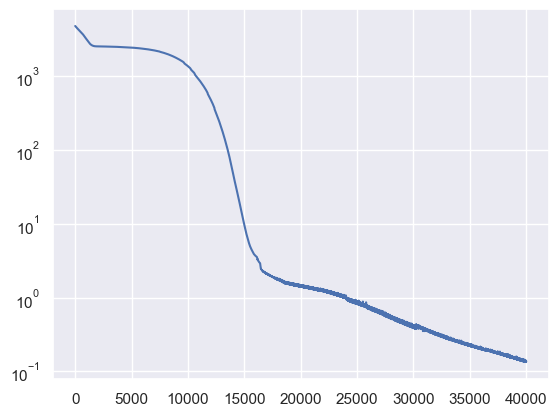

In [13]:
netdisc = NetDiscovery(1, 1, loss2=physics_loss_discovery, loss2_weight=1, epochs=40000, lr= 5e-6).to(DEVICE)

losses = netdisc.fit(t, T)
plt.plot(losses)
plt.yscale('log')

Parameter containing:
tensor([0.0053], requires_grad=True)


Text(0.5, 0, 'Time (s)')

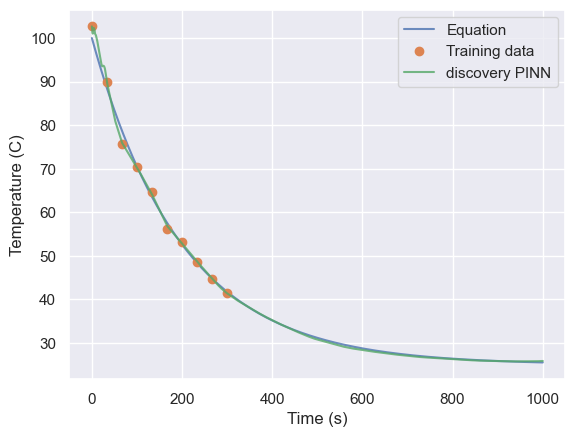

In [16]:
preds = netdisc.predict(times)
print(netdisc.r)

plt.plot(times, temps, alpha=0.8)
plt.plot(t, T, 'o')
plt.plot(times, preds, alpha=0.8)
plt.legend(labels=['Equation','Training data', 'discovery PINN'])
plt.ylabel('Temperature (C)')
plt.xlabel('Time (s)')

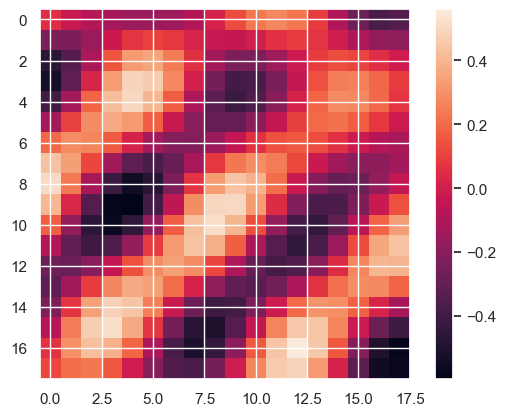

In [76]:
import tensorflow as tf
import numpy as np

# create an H0 for the physics loss as a smooth field generated by adding sine waves with random amplitudes and wavelengths
# def generate_smooth_field(size, num_waves=5):
#     x = np.linspace(0, 2 * np.pi, size)
#     y = np.linspace(0, 2 * np.pi, size)
#     x, y = np.meshgrid(x, y)
#     z = np.zeros((size, size), dtype=np.float32)
    
#     for _ in range(num_waves):
#         amplitude = np.random.uniform(-1.0, 1.0)
#         wavelength_x = np.random.uniform(0, 3)
#         wavelength_y = np.random.uniform(0, 3)
#         phase_x = np.random.uniform(0, 2 * np.pi)
#         phase_y = np.random.uniform(0, 2 * np.pi)
        
#         z += amplitude * np.sin(wavelength_x * x + phase_x) * np.sin(wavelength_y * y + phase_y)
    
#     z = tf.convert_to_tensor(z, dtype=tf.float32)
#     return z

def generate_smooth_field(size, num_waves=3):
            x = np.linspace(0, 2 * np.pi, size)
            y = np.linspace(0, 2 * np.pi, size)
            x, y = np.meshgrid(x, y)
            z = np.zeros((size, size), dtype=np.float32)
            
            for _ in range(num_waves):
                amplitude = np.random.uniform(-0.5, 0.5)
                wavelength_x = np.random.uniform(1, 2)
                wavelength_y = np.random.uniform(1, 2)
                phase_x = np.random.uniform(0, 2 * np.pi)
                phase_y = np.random.uniform(0, 2 * np.pi)
                
                z += amplitude * np.sin(wavelength_x * x + phase_x) * np.sin(wavelength_y * y + phase_y)
            
            z = tf.convert_to_tensor(z, dtype=tf.float32)
            return z

grid_size = 18
h0_phys = generate_smooth_field(grid_size, num_waves=4)
# h0_phys = tf.reshape(h0_phys, [-1])

plt.imshow(h0_phys.numpy())
plt.colorbar()

In [11]:
import tensorflow as tf
import numpy as np
import sys
import matplotlib.pyplot as plt
sys.path.append('../crater_diffusion/')
from crater_diffusion_utils import h_of_r_fasset2014, plot_crater_times, plot_crater_evolution

@tf.function
def find_nearest_neighbors(x, y, k=8):
    x1 = tf.expand_dims(x, 1)
    y1 = tf.expand_dims(y, 1)
    x2 = tf.expand_dims(x, 0)
    y2 = tf.expand_dims(y, 0)
    
    distances = (x1 - x2)**2 + (y1 - y2)**2
    _, indices = tf.nn.top_k(-distances, k=k+1)
    return indices[:, 1:]

@tf.function
def tf_gradient_batch(f, x, y):
    neighbor_indices = find_nearest_neighbors(x, y)
    x_neighbors = tf.gather(x, neighbor_indices)
    y_neighbors = tf.gather(y, neighbor_indices)
    f_neighbors = tf.gather(f, neighbor_indices)
    
    dx = x_neighbors - tf.expand_dims(x, 1)
    dy = y_neighbors - tf.expand_dims(y, 1)
    df = f_neighbors - tf.expand_dims(f, 1)
    
    A = tf.stack([dx, dy], axis=2)
    b = df[..., tf.newaxis]
    
    AT = tf.transpose(A, perm=[0, 2, 1])
    ATA = tf.matmul(AT, A)
    ATb = tf.matmul(AT, b)
    
    reg = tf.eye(2)[tf.newaxis, ...] * 1e-6
    gradients = tf.linalg.solve(ATA + reg, ATb)
    
    df_dx = gradients[:, 0, 0]
    df_dy = gradients[:, 1, 0]
    
    return df_dx, df_dy

def generate_smooth_field(size, num_waves=3):
    x = np.linspace(0, 2 * np.pi, size)
    y = np.linspace(0, 2 * np.pi, size)
    x, y = np.meshgrid(x, y)
    z = np.zeros((size, size), dtype=np.float32)
    
    for _ in range(num_waves):
        amplitude = np.random.uniform(-0.5, 0.5)
        wavelength_x = np.random.uniform(1, 2)
        wavelength_y = np.random.uniform(1, 2)
        phase_x = np.random.uniform(0, 2 * np.pi)
        phase_y = np.random.uniform(0, 2 * np.pi)
        
        z += amplitude * np.sin(wavelength_x * x + phase_x) * np.sin(wavelength_y * y + phase_y)
    
    z = tf.convert_to_tensor(z, dtype=tf.float32)
    return z

def generate_crater_field(size, D):
    r = D/2
    rmax = 2 * D
    x = np.linspace(-rmax, rmax, size)
    y = np.linspace(-rmax, rmax, size)
    x, y = np.meshgrid(x, y)
    r = np.sqrt(x**2 + y**2)
    z = h_of_r_fasset2014(r, D)
    z = tf.convert_to_tensor(z, dtype=tf.float32)
    return z

def prepare_physics_data(grid_size, r_max, length_scale, t_max, time_scale, time_size):
    # phys_point_grid_sizes = [16, 32, 46]
    # grid_size = 32
    # time_size = 6
    n_phys_points = grid_size * grid_size

    x_phys, y_phys = tf.meshgrid(
        tf.cast(tf.linspace(-r_max / length_scale, r_max / length_scale, grid_size), dtype=tf.float32),
        tf.cast(tf.linspace(-r_max / length_scale, r_max / length_scale, grid_size), dtype=tf.float32),
    )
    x_phys = tf.reshape(x_phys, [-1])
    y_phys = tf.reshape(y_phys, [-1])

    # h0_phys = generate_smooth_field(grid_size)
    h0_phys = generate_crater_field(grid_size, D = 300)
    h0_phys = tf.reshape(h0_phys, [-1])
        
    dt_phys_forward = tf.cast(tf.linspace(0.0, t_max / time_scale, time_size), dtype=tf.float32)
    dt_phys_backward = tf.linspace(tf.constant(-t_max / time_scale, dtype=tf.float32), tf.constant(0.0, dtype=tf.float32), time_size)
    
    return x_phys, y_phys, h0_phys, dt_phys_forward, dt_phys_backward, n_phys_points, grid_size, time_size

@tf.function
def compute_physics_loss(h0, x, y, dt):
    h = tf.TensorArray(dtype=tf.float32, size=dt.shape[0] + 1)
    d2h_dx2 = tf.TensorArray(dtype=tf.float32, size=dt.shape[0])
    d2h_dy2 = tf.TensorArray(dtype=tf.float32, size=dt.shape[0])
    
    h = h.write(0, h0)
    h_prev = h0
    dt_t = tf.where(tf.equal(dt, 0.0), 0.0, dt[1])
    for t in tf.range(1, dt.shape[0]):
        dh_dx, dh_dy = tf_gradient_batch(h_prev, x, y)
        d2h_dx2_t, _ = tf_gradient_batch(dh_dx, x, y)
        _, d2h_dy2_t = tf_gradient_batch(dh_dy, x, y)

        dt_t_ = dt_t[t]
        
        h_t = h_prev + dt_t_ * (d2h_dx2_t + d2h_dy2_t)
        
        h = h.write(t, h_t)
        d2h_dx2 = d2h_dx2.write(t - 1, d2h_dx2_t)
        d2h_dy2 = d2h_dy2.write(t - 1, d2h_dy2_t)
        
        h_prev = h_t
    
    return h.stack(), d2h_dx2.stack(), d2h_dy2.stack()

D = 300
r_max = 2 * D
length_scale = D / 2
kappa = 5.5 
time_scale = length_scale**2 / kappa
dx_m = 10
grid_size = tf.cast(r_max / dx_m, dtype=tf.int32)
max_dt = (dx_m**2) / (4 * kappa)
max_dt = (np.floor(max_dt * 100) / 100)
t_max = 3000
time_size = int(np.ceil(t_max / max_dt))

x_phys, y_phys, h0_phys, dt_phys_forward, dt_phys_backward, n_phys_points, grid_size, time_size = prepare_physics_data(grid_size, r_max, length_scale, t_max, time_scale, time_size)

h, d2h_dx2, d2h_dy2 = compute_physics_loss(h0_phys, x_phys, y_phys, dt_phys_forward)


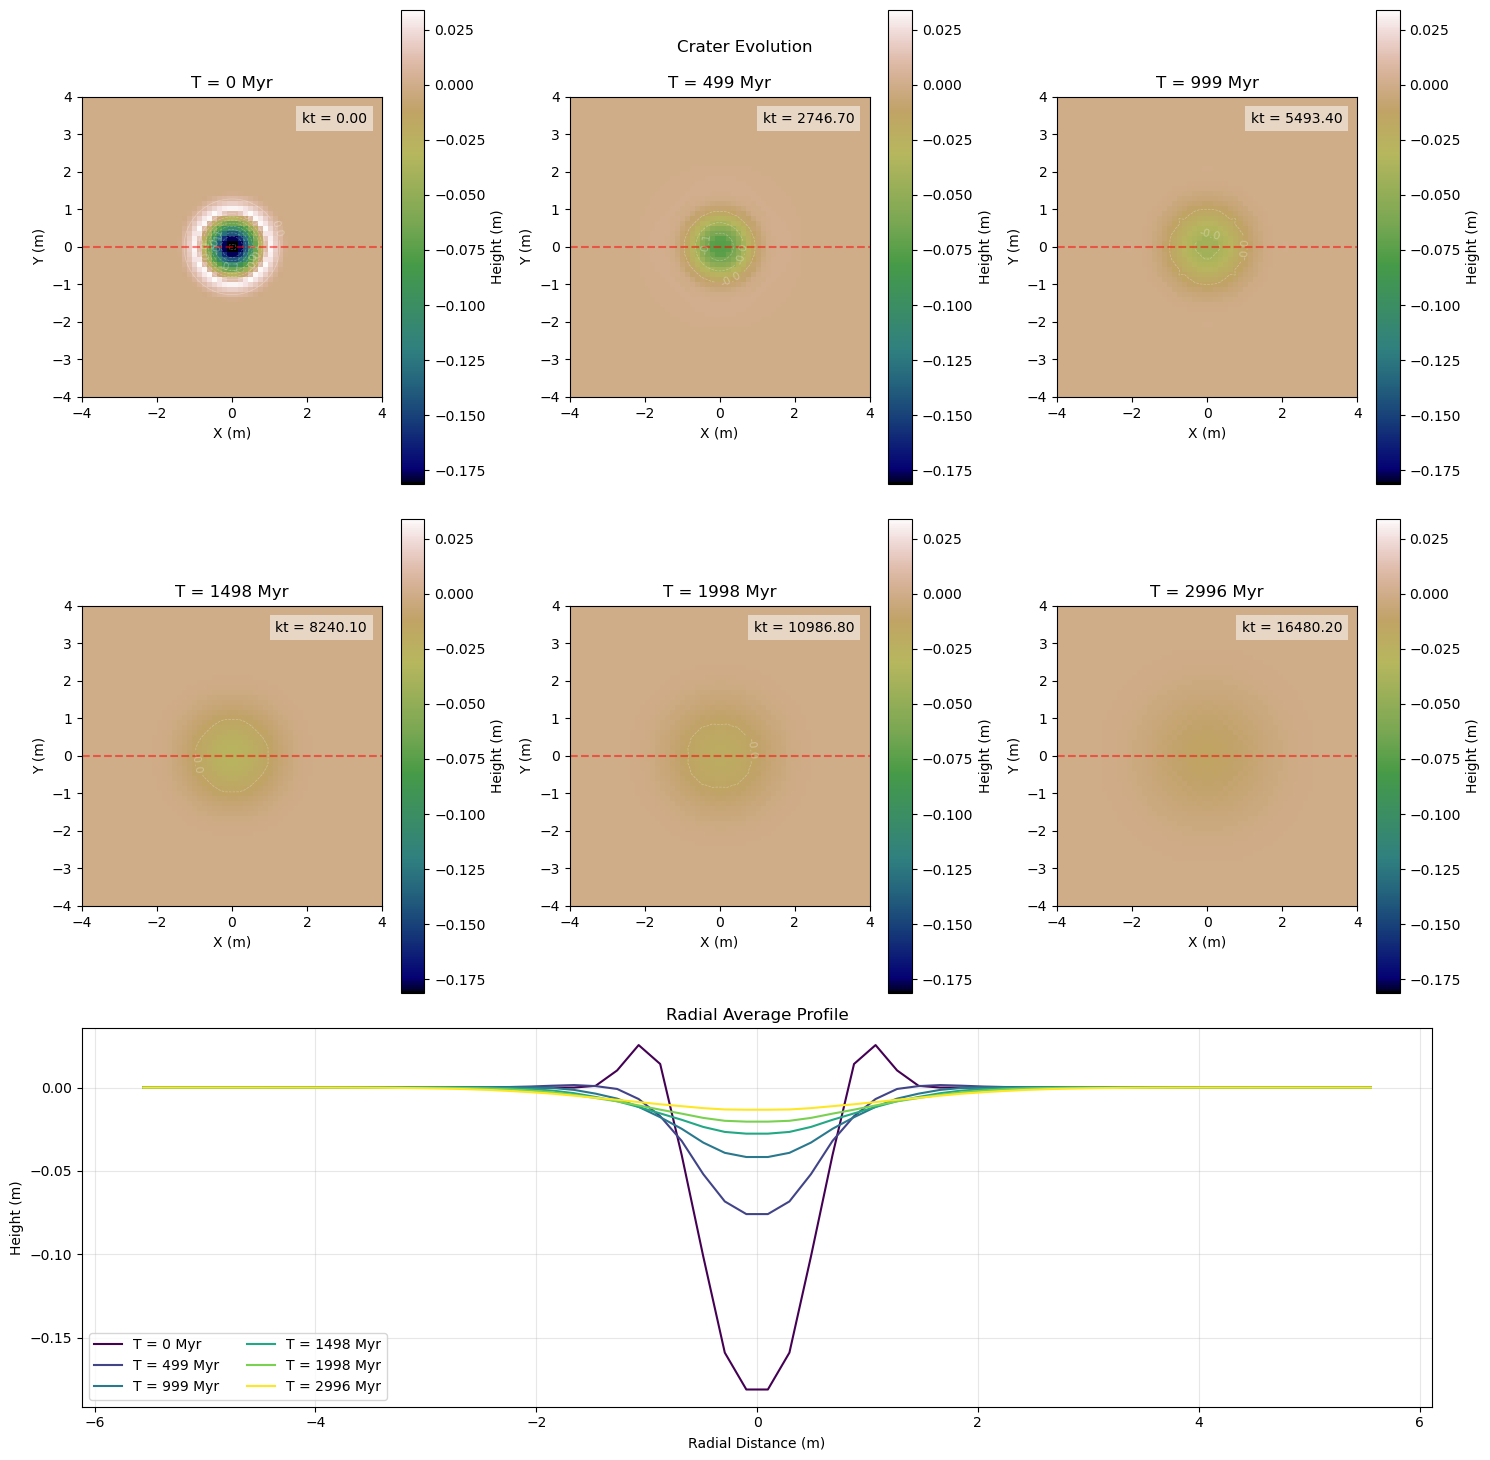

In [12]:
# vmin = h.numpy().min()
# vmax = h.numpy().max()
# a = np.sqrt(time_size)
# a = int(np.floor(a))
# b = int(np.ceil(a))
# fig, axes = plt.subplots(a, b, figsize=(20, 16))
# axes = axes.flatten()
# for i, ax in enumerate(axes):
#     im = ax.imshow(h.numpy()[i, :].reshape(grid_size, grid_size), vmin=vmin, vmax=vmax, cmap='gist_earth')
#     fig.colorbar(im, ax=ax)
# plt.show()

# times = [max_dt * i for i in range(time_size)]
h_plot = np.array([h.numpy()[i, :].reshape(grid_size, grid_size) for i in range(time_size)])
# Clip anomalous values from h
# h_plot = [np.clip(h_img, -50, 50) for h_img in h_plot]
# plot_times = np.array(times)[np.linspace(0, time_size - 1, 6, dtype=int)]
time_size_ = time_size 
plot_times = [0, time_size_//6, time_size_//3, time_size_//2, 2*time_size_//3, time_size-1]
plot_times = [int(pt) for pt in plot_times]
# plot_times = [0, 500, 1000, 1500, 2000, 2500, 3000]
# plot_times = [max_dt*t for t in plot_times]

fig = plot_crater_evolution(h_plot, np.unique(x_phys.numpy()), np.unique(y_phys.numpy()), max_dt, kappa, plot_times)
# fig.show()